To get started, answer the following questions using just the fullsample.csv jobs dataset:

Calculate some descriptive statistics for how many jobs per hour are being completed. What does the completions per hour look like over the time span of the dataset? Are there weekly trends, and has it been increasing over the last year?

Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. We also expect that most job completions will be in the "production" partition, but is this actually true?

In [46]:
import pandas as pd
import datetime
from datetime import datetime
from datetime import timedelta
import time
import re
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib

In [2]:
fullsample_df = pd.read_pickle("PICKLE_all")
fullsample_completed = pd.read_pickle("PICKLE_complete")

In [145]:
date_as_index = fullsample_df.set_index("END")

In [47]:
fullsample_df['BEGIN'].min()  #Earliest date is Oct. 1,2020 @ 12:03:08 AM
fullsample_df['END'].max()    #Latest date is Oct. 7, 2021 @ 8:41:11 PM

Timestamp('2020-10-01 00:03:08')

In [171]:
date_as_index.groupby(date_as_index.index.day).count()

,JOBID,STATE,BEGIN,REQMEM,USEDMEM (Mn),REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,Unit
END,,,,,,,,,,,,
1.0,312391,312391,312391,312391,312391,312391,312391,312391,312391,312391,312391,312391
2.0,279338,279338,279338,279338,279338,279338,279338,279338,279338,279338,279338,279338
3.0,342639,342639,342639,342639,342639,342639,342639,342639,342639,342639,342639,342639
4.0,275084,275084,275084,275084,275084,275084,275084,275084,275084,275084,275084,275084
5.0,243866,243866,243866,243866,243866,243866,243866,243866,243866,243866,243866,243866
6.0,208397,208397,208397,208397,208397,208397,208397,208397,208397,208397,208397,208397
7.0,229395,229395,229395,229395,229395,229395,229395,229395,229395,229395,229395,229395
8.0,222242,222242,222242,222242,222242,222242,222242,222242,222242,222242,222242,222242
9.0,250320,250320,250320,250320,250320,250320,250320,250320,250320,250320,250320,250320


In [14]:
#fullsample_df['USEDMEM'] = PICKLE['USEDMEM'].str.split(r'([a-zA-Z]+)').str[0]
#fullsample_df.rename(columns={'USEDMEM': 'USEDMEM (Mn)'})

# hours elapsed from earliest date to latest date is 8924.63 rounded to nearest hundredth 
t1 = fullsample_df['BEGIN'].min()
t2 = fullsample_df['END'].max()
duration_in_hr = ((t2 - t1).total_seconds())/3600

# 7,375,084 completed jobs including all jobs from some array
7395885/duration_in_hr

828.7045566106772

In [5]:
fullsample_df.describe()

,REQMEM,USEDMEM (Mn),REQTIME,USEDTIME,NODES,CPUS
count,7.395885e+06,7.395885e+06,7395885,7395885,7.395885e+06,7.395885e+06
mean,1.239243e+04,2.640674e+03,0 days 22:18:49.120052569,0 days 03:48:09.806426005,1.005995e+00,1.861186e+00
std,2.608068e+04,8.836804e+03,1 days 14:49:17.246008506,0 days 12:47:31.941130706,4.292460e-01,3.158301e+00
min,1.000000e+00,0.000000e+00,0 days 00:01:00,0 days 00:00:00,1.000000e+00,0.000000e+00
25%,2.048000e+03,1.389100e+02,0 days 01:30:00,0 days 00:02:37,1.000000e+00,1.000000e+00
50%,4.096000e+03,3.758800e+02,0 days 08:00:00,0 days 00:13:54,1.000000e+00,1.000000e+00
75%,1.433600e+04,1.825000e+03,1 days 00:00:00,0 days 01:28:10,1.000000e+00,1.000000e+00
max,1.026375e+06,9.925798e+05,364 days 14:00:00,67 days 22:14:22,5.000000e+02,1.280000e+02


<AxesSubplot:xlabel='END'>

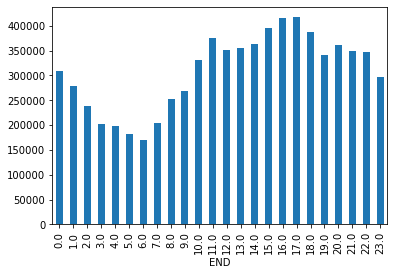

In [51]:
date_as_index = fullsample_df.set_index("END")


#by_month['JOBID'].plot(kind='bar'),

#by_day['JOBID'].plot(kind='bar')

by_hour=date_as_index.groupby(date_as_index.index.hour).count()
by_hour['JOBID'].plot(kind='bar')


#by_week=date_as_index.groupby(date_as_index.index.week).count()


C:\Users\j0909\AppData\Local\Temp/ipykernel_16636/3417741958.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  date_as_index.groupby(date_as_index.index.week).count().plot.line(legend='');


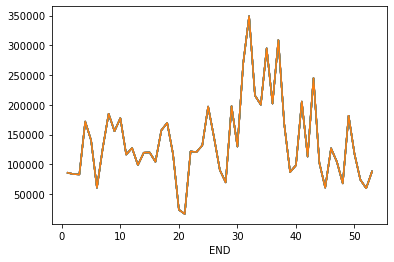

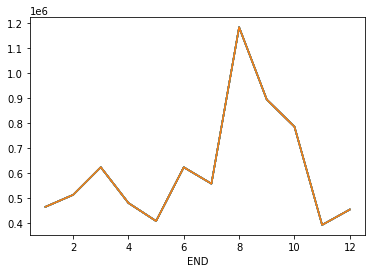

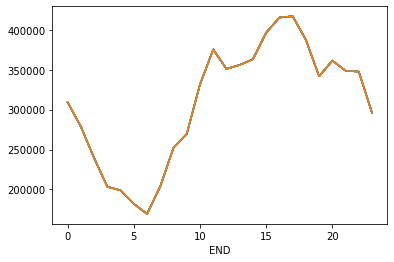

In [52]:
date_as_index.groupby(date_as_index.index.week).count().plot.line(legend='');
date_as_index.groupby(date_as_index.index.month).count().plot.line(legend='');
date_as_index.groupby(date_as_index.index.hour).count().plot.line(legend='');

In [57]:
#pd.options.display.max_rows=1000
date_as_index.groupby( [date_as_index.index.year, date_as_index.index.month, date_as_index.index.day, date_as_index.index.hour] ).count().head(100)


pd.plotting.autocorrelation_plot(df["R"].resample("1y").median())

NameError: name 'df' is not defined

In [53]:
pd.options.display.max_rows=1000
fullsample_df['STATE'].value_counts()

COMPLETED              7375084
CANCELLED                 9055
FAILED                    3766
CANCELLED by 9201         1776
OUT_OF_MEMORY             1739
CANCELLED by 776869        702
CANCELLED by 486628        566
CANCELLED by 0             474
PENDING                    443
CANCELLED by 169069        381
CANCELLED by 308082        308
CANCELLED by 9202          209
RUNNING                    208
CANCELLED by 9203          191
CANCELLED by 760367         92
CANCELLED by 9219           83
CANCELLED by 9221           71
CANCELLED by 750245         67
CANCELLED by 784793         52
CANCELLED by 200557         41
CANCELLED by 879907         26
CANCELLED by 855227         25
CANCELLED by 515381         25
CANCELLED by 454080         24
CANCELLED by 879765         23
CANCELLED by 788919         23
CANCELLED by 341210         21
CANCELLED by 787621         21
CANCELLED by 895419         20
CANCELLED by 505355         18
CANCELLED by 895426         16
CANCELLED by 885613         15
CANCELLE

In [75]:
fullsample_completed['PARTITION'].value_counts(normalize=True).mul(100).round(4).astype(str) + '%'


production              94.9438%
nogpfs                   1.9886%
pascal                   1.6673%
sam                      0.8809%
turing                   0.2798%
maxwell                  0.1489%
cgw-maizie               0.0578%
debug                    0.0194%
cgw-platypus              0.005%
cgw-dsi-gw               0.0031%
cgw-capra1                0.002%
cgw-dougherty1           0.0015%
cgw-horus                0.0008%
cgw-cqs1                 0.0004%
cgw-hanuman              0.0003%
cgw-sideshowbob          0.0002%
cgw-vm-qa-flatearth1     0.0001%
cgw-tbi01                0.0001%
Name: PARTITION, dtype: object

In [55]:
fail = fullsample_df.loc[fullsample_df['STATE']!='COMPLETED']
fail.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM (Mn),REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,Unit
0,30616928,RUNNING,2021-07-31 22:15:00,NaT,2048,0.00,0 days 10:04:00,67 days 22:14:22,1,1,production,0:0,Mn
18,31418105,NODE_FAIL,2021-08-19 10:09:50,2021-09-17 08:45:10,92160,0.00,41 days 16:00:00,28 days 22:35:20,1,8,cgw-dougherty1,1:0,Mn
42,31669402,CANCELLED,2021-08-28 10:53:59,2021-09-05 10:53:57,65536,5229.75,8 days 00:00:00,7 days 23:59:58,9,10,production,0:15,Mn
1023,31798622,CANCELLED,2021-08-31 02:46:09,2021-09-05 02:46:09,40960,1440.95,5 days 00:00:00,5 days 00:00:00,4,4,turing,0:15,Mn
1029,31798672,CANCELLED,2021-08-31 02:53:48,2021-09-05 02:54:09,40960,1438.46,5 days 00:00:00,5 days 00:00:21,4,4,turing,0:15,Mn


42: CXED 0:15
7394977:	OUT_OF_MEMORY 0:125
x: cxed by user # 0.0


In [75]:
fullsample_completed

,JOBID,STATE,BEGIN,END,REQMEM,Unit,USEDMEM (Mn),REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144,Mn,20604.62,30 days 00:00:00,30 days 00:00:23,1,1,cgw-platypus,0:0
1,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800,Mn,57553.77,30 days 00:00:00,30 days 00:00:14,1,32,cgw-tbi01,0:0
2,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536,Mn,20577.96,29 days 04:00:00,29 days 04:00:04,1,8,cgw-platypus,0:0
3,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384,Mn,9733.43,24 days 09:00:00,24 days 09:00:17,1,1,production,0:0
4,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384,Mn,9708.04,24 days 09:00:00,20 days 08:32:27,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7375079,25493434,COMPLETED,2020-10-31 23:39:00,2020-10-31 23:40:46,2000,Mn,0.09,2 days 00:00:00,0 days 00:01:46,1,1,sam,0:0
7375080,25493435,COMPLETED,2020-10-31 23:39:13,2020-10-31 23:40:38,2000,Mn,187.92,2 days 00:00:00,0 days 00:01:25,1,1,sam,0:0
7375081,25493476,COMPLETED,2020-10-31 23:46:29,2020-10-31 23:49:43,4096,Mc,803.97,0 days 12:00:00,0 days 00:03:14,1,1,production,0:0
7375082,25493515,COMPLETED,2020-10-31 23:49:44,2020-10-31 23:51:40,2000,Mn,0.09,2 days 00:00:00,0 days 00:01:56,1,1,sam,0:0


In [12]:
#fullsample_completed['BEGIN'].min()  #Earliest date is Oct. 1,2020 @ 12:03:08 AM
#fullsample_completed['END'].max()    #Latest date is Oct. 7, 2021 @ 8:41:11 PM
#7375084 
begin = fullsample_completed['BEGIN'].min()
end = fullsample_completed['END'].max()
duration_in_hr = ((t2 - t1).total_seconds())/3600
7375084/duration_in_hr

826.373816816581

In [33]:
series = hour_slice
result = seasonal_decompose(hour_slice, model='multiplicative')
print(result.trend)
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [58]:
hour_slice

,JOBID
END,
0.0,309141
1.0,278551
2.0,239237
3.0,203253
4.0,198785
5.0,181828
6.0,169256
7.0,203939
8.0,252337


<AxesSubplot:xlabel='END'>

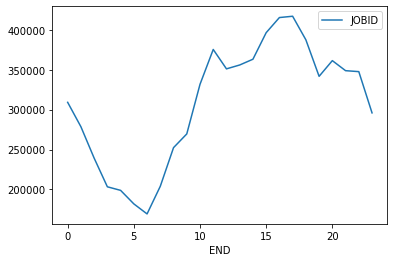

In [52]:
by_hour=date_as_index.groupby(date_as_index.index.hour).count()
hour_slice = by_hour['JOBID'].to_frame()
hour_slice.plot()

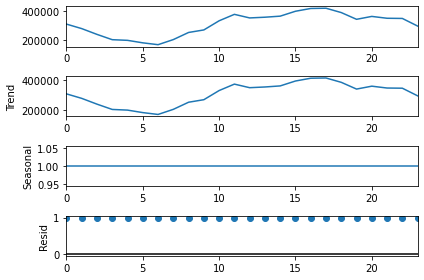

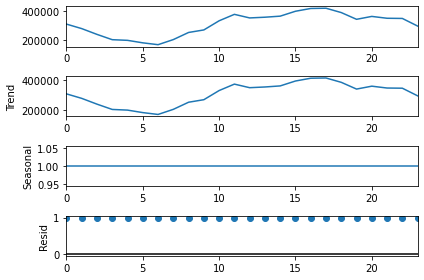

In [51]:
series = hour_slice
result = seasonal_decompose(hour_slice, model='multiplicative', period=1)
#print(result.trend)
result.plot()
#print(result.seasonal)
#print(result.resid)
#print(result.observed)

In [74]:
by_hour['rolling_7_day_average'] = by_hour.rolling('hour')['JOBID'].mean()


ValueError: window must be an integer 0 or greater

In [76]:
by_hour.describe()

,JOBID,STATE,BEGIN,REQMEM,USEDMEM (Mn),REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,Unit
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000,308134.750000
std,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785,76993.272785
min,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000,169256.000000
25%,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000,249062.000000
50%,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000,336723.500000
75%,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000,361857.250000
max,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000,417068.000000


In [84]:
just_2020 = fullsample_df[fullsample_df['END'].dt.year == 2020]

In [107]:
date_as_index = just_2020.set_index("END", inplace=True)

In [132]:
TEST = just_2020.groupby(pd.Grouper(key='BEGIN', freq='1D')).count()

In [133]:
TEST['JOBID'].idxmax()

Timestamp('2020-10-25 00:00:00', freq='D')

In [134]:
TEST['JOBID'].sort_values(ascending=True)

BEGIN
2020-11-26      4166
2020-12-27      4830
2020-12-31      5470
2020-12-25      5935
2020-11-03      6487
               ...  
2020-10-09     39866
2020-10-10     43755
2020-10-24     50234
2020-12-01     56275
2020-10-25    104696
Name: JOBID, Length: 92, dtype: int64

In [136]:
slurm_wrapper_ce5 = pd.read_csv('slurm_wrapper_ce5.log',sep = ' - ', engine = 'python')


In [139]:
pd.set_option('display.width', None)

slurm_wrapper_ce5

,2020-10-16 08:15:39.278699,user 0,retry 0,time 0.07347559928894043,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '-S', '2020-10-10']"
0,2020-10-16 08:18:08.313309,user 0,retry 0,time 0.18363237380981445,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
1,2020-10-16 08:22:48.128689,user 0,retry 0,time 0.07547116279602051,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
2,2020-10-16 08:25:13.257408,user 0,retry 0,time 0.09484362602233887,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
3,2020-10-16 08:31:01.460723,user 0,retry 0,time 0.07498788833618164,returncode 0,"command ['/usr/bin/sacct', '-u', 'appelte1', '..."
4,2020-10-16 08:31:57.896479,user 9201,retry 0,time 0.12703871726989746,returncode 0,"command ['/usr/bin/scancel', '24994284']"
...,...,...,...,...,...,...
4770887,2021-10-07 21:58:06.738329,user 9203,retry 0,time 0.02677178382873535,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u..."
4770888,2021-10-07 21:58:15.931559,user 9201,retry 0,time 0.04166150093078613,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u..."
4770889,2021-10-07 21:58:48.900136,user 9221,retry 0,time 0.14348959922790527,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u..."
4770890,2021-10-07 21:59:11.314056,user 9203,retry 0,time 0.026599407196044922,returncode 0,"command ['/usr/bin/squeue', '-o', '%i %T', '-u..."
